# FAST-UAV - Off-design mission performance
*Author: Félix Pollet - 2023* <br>

This notebook provides an example of how to compute the performance of a pre-defined UAV design for any operational mission.

For this purpose, we will re-use the results from a previous design optimization process, stored in the [problem_outputs_DJI_M600_mdo.xml](../data/problem_outputs_DJI_M600_mdo.xml) file.

In [1]:
# Import required librairies
import os.path as pth
import openmdao.api as om
import logging
import warnings
import shutil
import fastoad.api as oad
from time import time
import matplotlib.pyplot as plt
from fastuav.utils.postprocessing.analysis_and_plots import *

# Declare paths to folders and files
DATA_FOLDER_PATH = "../data"
CONFIGURATIONS_FOLDER_PATH = "../configurations"
WORK_FOLDER_PATH = "./workdir"
SOURCE_FILE = pth.join(DATA_FOLDER_PATH, "problem_outputs_DJI_M600_mdo.xml")  # The source file is the output file of a previous design optimization process.

# For having log messages display on screen
#logging.basicConfig(level=logging.INFO, format="%(levelname)-8s: %(message)s")
#warnings.filterwarnings(action="ignore")

# For using all screen width
from IPython.display import display, HTML, IFrame
display(HTML("<style>.container { width:95% !important; }</style>"))

The problem definition is slightly different from that used for design optimization. In fact, it consists of a simple evaluation of the performance module. No optimization of any kind is performed, since the design is already known. Have a look at the [multirotor_performance.yaml](../configurations/multirotor_performance.yaml) file.

In [2]:
CONFIGURATION_FILE = pth.join(WORK_FOLDER_PATH, "configuration.yaml")
oad.generate_configuration_file(
    CONFIGURATION_FILE, overwrite=True, distribution_name="fastuav", sample_file_name="multirotor_performance.yaml"
)

'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\configuration.yaml'

## 1. Setting up the performance analysis

The model used for the performance analysis solely consists of the `Missions` module. No design models for the components is used, only the performance models.<br>

```yaml
model:
    missions:
        id: fastuav.performance.mission
        file_path: ../../missions/missions_multirotor.yaml
```

The definition of the missions, routes and flight phases are defined in the [mission file](../missions/missions_multirotor.yaml) whose path is provided in the configuration file. A mission is defined as an assembly of routes, which are in turn defined as an assembly of flight phases. Each flight phase is identified by a `phase_id` that describes it. The phase identifiers associated with the multirotor drones are the `vertical climb`, the `multirotor cruise` and the `hover`.

In [4]:
N2_FILE = pth.join(WORK_FOLDER_PATH, "n2.html")
oad.write_n2(CONFIGURATION_FILE, N2_FILE, overwrite=True)
from IPython.display import IFrame
IFrame(src=N2_FILE, width="100%", height="500px")

## 2. Run the performance analysis

To run a performance analysis, you need an XML file describing the drone design. As explained earlier, this can be the output of a design problem (see the [Multirotor Design Notebook](./1_Multirotor_Design.ipynb)).

Let's generate the temporary file and check the values of the parameters.

In [5]:
oad.generate_inputs(CONFIGURATION_FILE, SOURCE_FILE, overwrite=True)

The following variables have NaN values: ['mission:operational_1:main_route:payload:mass', 'mission:operational_1:main_route:takeoff:altitude', 'mission:operational_1:main_route:cruise:altitude', 'mission:operational_1:main_route:climb:rate', 'mission:operational_1:main_route:climb:speed', 'mission:operational_1:dISA', 'mission:operational_1:main_route:climb:payload:power', 'mission:operational_1:main_route:hover:duration', 'mission:operational_1:main_route:hover:payload:power', 'mission:operational_1:main_route:cruise:distance', 'mission:operational_1:main_route:cruise:speed', 'mission:operational_1:main_route:cruise:payload:power', 'mission:operational_1:diversion:payload:mass', 'mission:operational_1:diversion:cruise:altitude', 'mission:operational_1:diversion:hover:duration', 'mission:operational_1:diversion:hover:payload:power', 'mission:operational_1:diversion:cruise:distance', 'mission:operational_1:diversion:cruise:speed', 'mission:operational_1:diversion:cruise:payload:power',

'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\problem_inputs.xml'

In [6]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_inputs.xml")
oad.variable_viewer(INPUT_FILE)

C:\Users\f.pollet.ISAE-SUPAERO\AppData\Roaming\Python\Python38\site-packages\jupyter_client\session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


You can use the `VariableViewer` to fill in the values for the mission profile, in the 'mission' menu (do not forget to save!).

Once, it is done, we can run the problem using `evaluate_problem`...

In [7]:
eval_problem = oad.evaluate_problem(CONFIGURATION_FILE, overwrite=True)

... and have a look at the results.

In [8]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_outputs.xml")
oad.variable_viewer(OUTPUT_FILE)

## 3. Analysis and plots

For the moment, the post processing plots are limited to the visualization of the energy consumed over the mission. If several mission have been computed, you can compare them on the same plot.

[235.72448432744093, 226.22032143919114] ['diversion', 'main_route'] ['diversion<br>235 [Wh] (51.0%)', 'main_route<br>226 [Wh] (49.0%)']
['diversion<br>235 [Wh] (51.0%)', 'main_route<br>226 [Wh] (49.0%)']
['cruise<br>126 [Wh] ', 'hover<br>109 [Wh] ', 'climb<br>17 [Wh] ', 'cruise<br>85 [Wh] ', 'hover<br>123 [Wh] ']


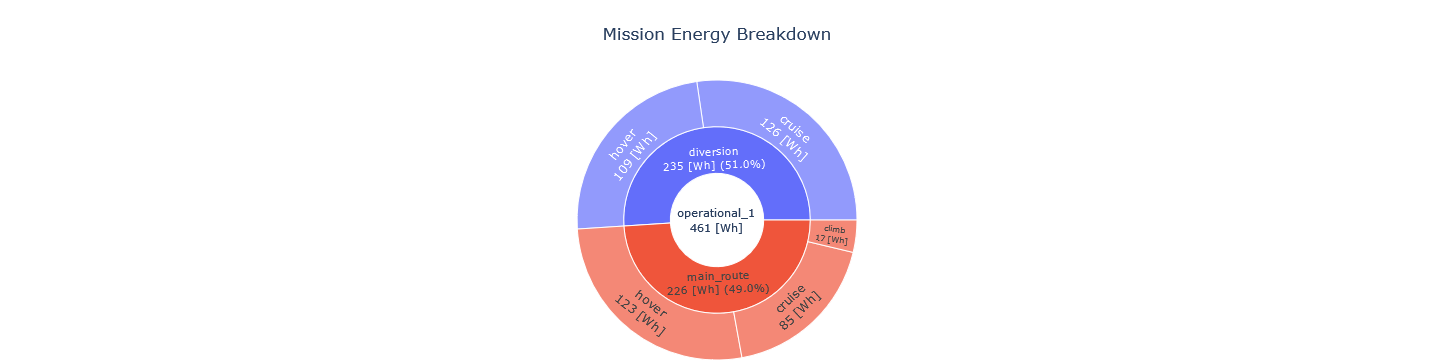

In [31]:
mission_name = "operational_1"  # name of the mission to plot
fig = energy_breakdown_sun_plot_drone(OUTPUT_FILE, mission_name=mission_name)
fig.show()

[294.54964738618526, 236.68745005672827] ['route_1', 'route_2'] ['route_1<br>294 [Wh] (55.4%)', 'route_2<br>236 [Wh] (44.6%)']
['route_1<br>294 [Wh] (55.4%)', 'route_2<br>236 [Wh] (44.6%)']
['climb<br>36 [Wh] ', 'cruise<br>258 [Wh] ', 'hover<br>236 [Wh] ']


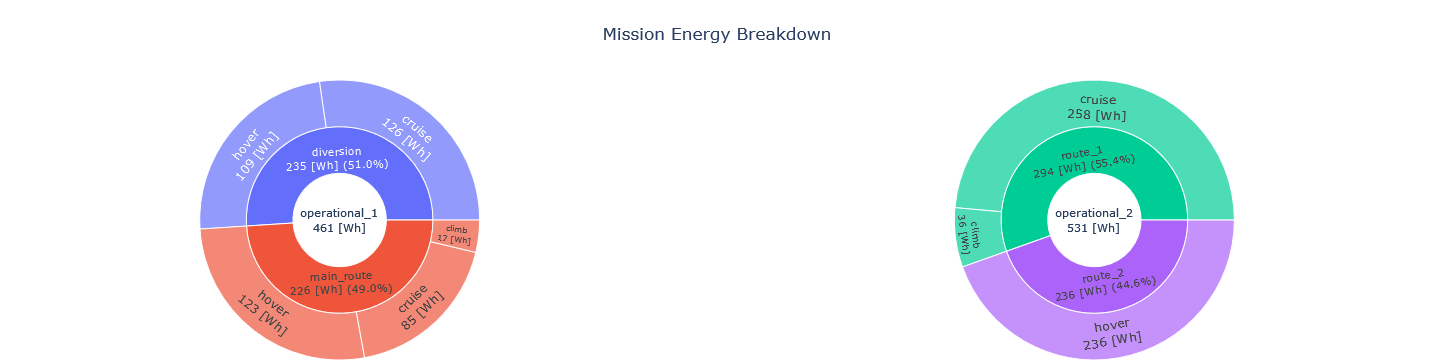

In [32]:
mission_name = "operational_2"  # secondary mission
fig = energy_breakdown_sun_plot_drone(OUTPUT_FILE, mission_name=mission_name, fig=fig)
fig.show()